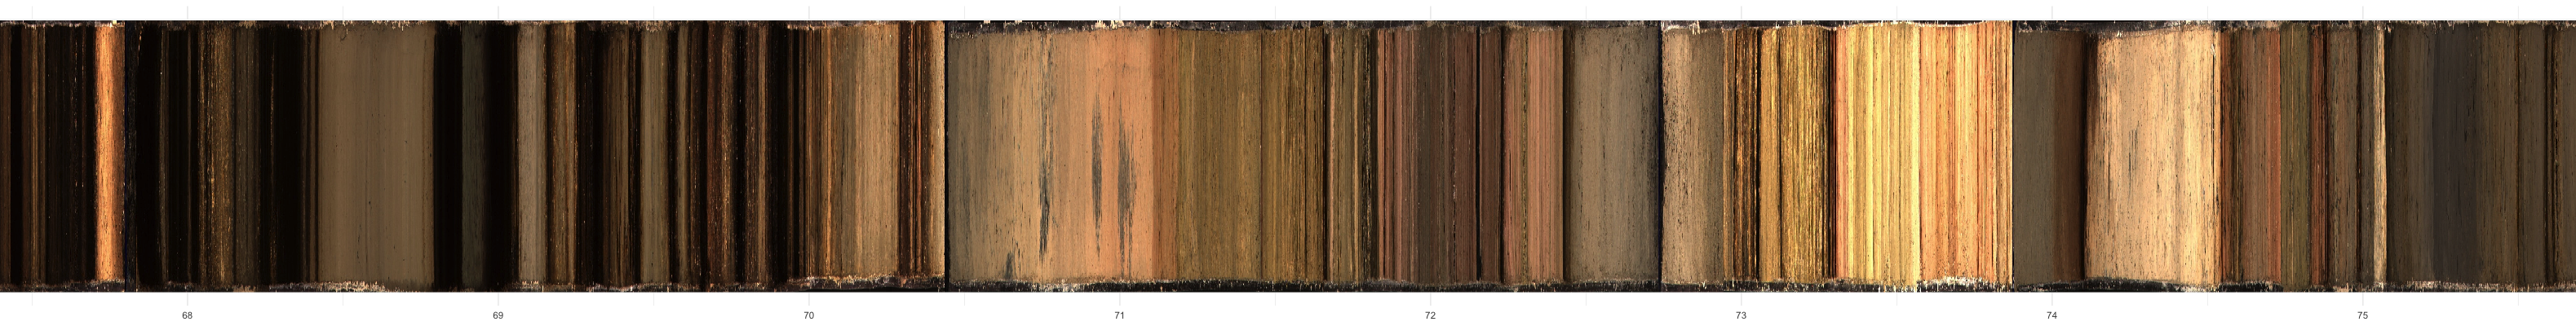

#   Data cleaning

The three primary data sets to clean up are described below: XRF, clastic flux, and coulometry. The coulometry data will be further separated into carbon, isotope, and density data sets. Data processing steps include formatting data frames, checking for missing and erroneous values, and assessing spread and outliers.

### <b>X-Ray Fluorescence (XRF)</b>
XRF instruments use an optical core scanner to collect counts of most elements from aluminum (atomic #13) to uranium (#92). Elements of interest in this study are aluminum, silicon, titanium, and potassium (Al, Si, Ti, K). Two sets of XRF data were generated that need to be tidied and merged.

In [299]:
# rename and select only necessary columns from each data set
xrf_upper <- xrf_upper |> 
  rename(age = bacon22,
         age_min = bacon22min95,
         age_max = bacon22max95,
         depth_m = compDepthCol,
         aluminum = Al.corrected,
         silicon = Si.corrected,
         titanium = Ti.corrected,
         potassium = K.corrected,
         section_depth_cm = Section.Depth..cm.) |>
  select(SectionID, section_depth_cm, age, age_min, age_max, depth_m, aluminum, silicon, titanium, potassium)
  
xrf_lower <- xrf_lower |> 
  rename(age = bacon22,
         age_min = bacon22min95,
         age_max = bacon22max95,
         depth_m = compDepthCol,
         aluminum = Al,
         silicon = Si,
         titanium = Ti,
         potassium = K,
         section_depth_cm = Section.Depth.cm.) |>
  select(SectionID, section_depth_cm, age, age_min, age_max, depth_m, aluminum, silicon, titanium, potassium)

# combine the two data sets
xrf_full <- rbind(xrf_upper, xrf_lower)
glimpse(xrf_full)

Rows: 4,765
Columns: 10
$ SectionID        <chr> "PLJL-JUN15-6A-1L-1", "PLJL-JUN15-6A-1L-1", "PLJL-JUN…
$ section_depth_cm <dbl> 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0…
$ age              <dbl> 236.0, 245.5, 255.0, 264.0, 273.0, 282.5, 292.0, 301.…
$ age_min          <dbl> 66.0, 81.0, 96.0, 106.5, 117.0, 122.5, 128.0, 132.5, …
$ age_max          <dbl> 388.0, 391.5, 395.0, 399.0, 403.0, 407.5, 412.0, 418.…
$ depth_m          <dbl> 0.150, 0.155, 0.160, 0.165, 0.170, 0.175, 0.180, 0.18…
$ aluminum         <dbl> NA, 215.9027, 140.2870, 169.1403, 170.1353, 171.1302,…
$ silicon          <dbl> NA, 487.0661, 445.9882, 359.6409, 334.4912, 442.6349,…
$ titanium         <dbl> NA, 1166.9155, 658.6660, 781.3742, 778.9992, 938.9157…
$ potassium        <dbl> NA, 878.814566, 607.107677, 473.269863, 316.050743, 1…


In [300]:
# Count and remove unnecessary NAs
colSums(is.na(xrf_full)) 
xrf_full <- xrf_full |> drop_na()

SectionID section_depth_cm              age          age_min 
               0                0             1261             1261 
         age_max          depth_m         aluminum          silicon 
            1261             1261                1                1 
        titanium        potassium 
               1                1

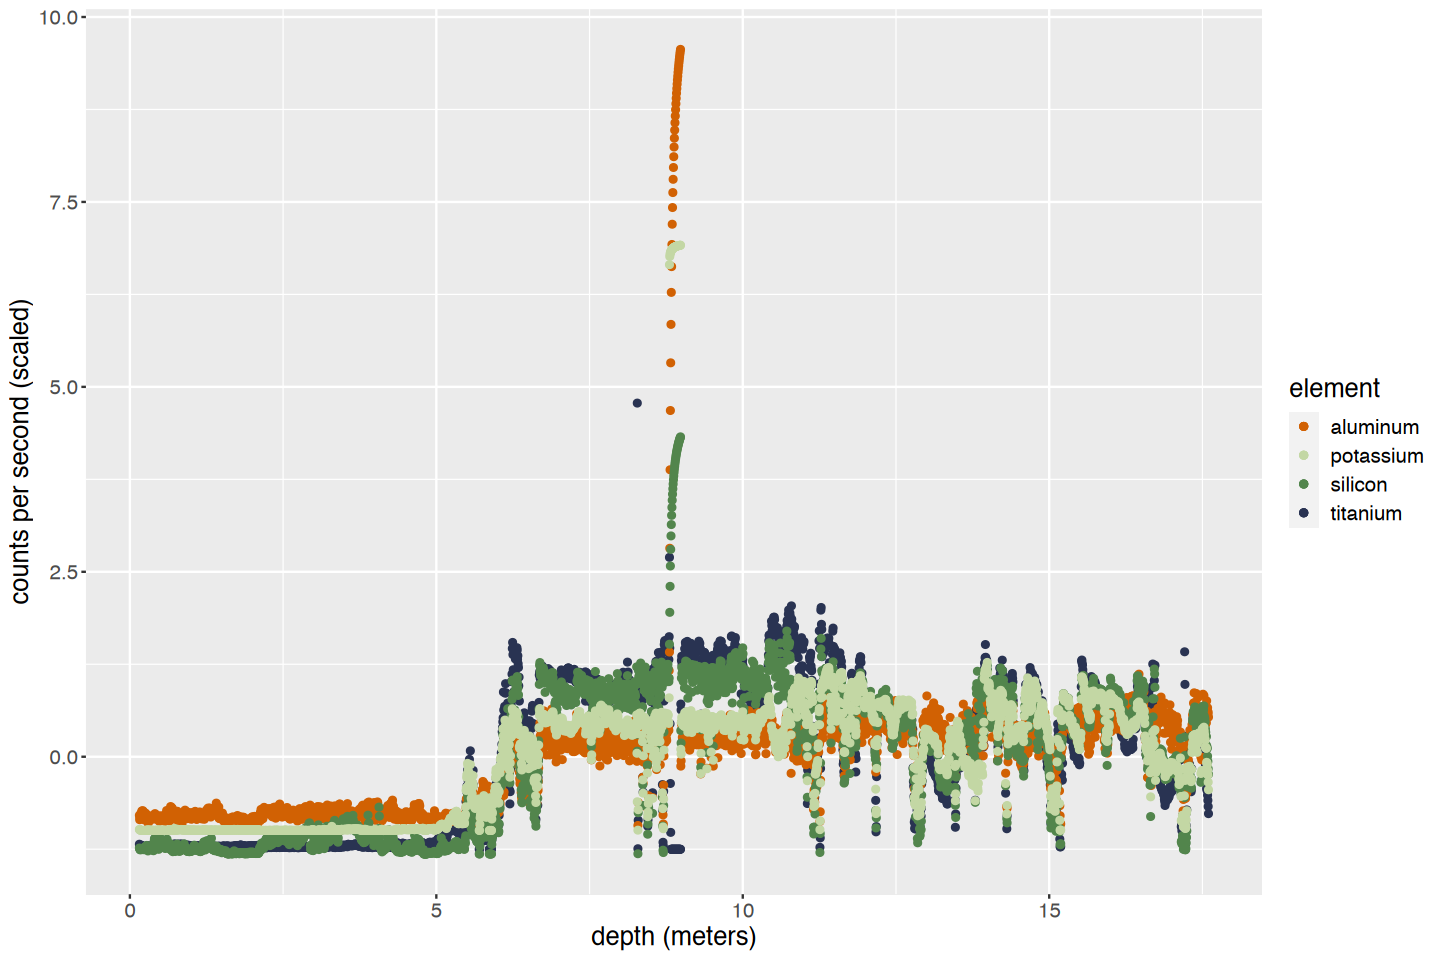

In [301]:
# Scatter plot to check for outliers; variables are scaled so they can be viewed on the same plot

options(repr.plot.width = 12, repr.plot.height = 8)
xrf_scatter_plot <- ggplot(
  data = xrf_full,
  mapping = aes(x = depth_m)) +
  geom_point(mapping = aes(y = scale(titanium), color = 'titanium')) +
  geom_point(mapping = aes(y = scale(aluminum), color = 'aluminum')) +
  geom_point(mapping = aes(y = scale(silicon), color = 'silicon')) +
  geom_point(mapping = aes(y = scale(potassium), color = 'potassium')) +
  scale_colour_manual(name="element",
                      values=c("#D16103", "#C3D7A4", "#52854C", "#293352")) + 
  labs(y = "counts per second (scaled)") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

suppressWarnings(print(xrf_scatter_plot))

Since these outliers are present for all elements in the same depth range, we can assume they arose from instrument error and can be removed. Same goes for any rows where <b>all four</b> elements have counts of zero:

In [302]:
# Remove outliers - filter rows with Al and Ti values below thresholds
xrf_filtered <- xrf_full |> filter(aluminum < 2500 & titanium < 100000)

In [303]:
# Return a subset of data where counts for all elements are zero
zeroes <- xrf_filtered |> filter(titanium == 0 & aluminum == 0 & silicon == 0 & potassium == 0) |> 
  select(!c(age_min, age_max)) 

# Remove those rows from the XRF data frame
xrf <- anti_join(xrf_filtered, zeroes) 

Joining with `by = join_by(SectionID, section_depth_cm, age, depth_m, aluminum,
silicon, titanium, potassium)`


#### A final look at the cleaned data set:

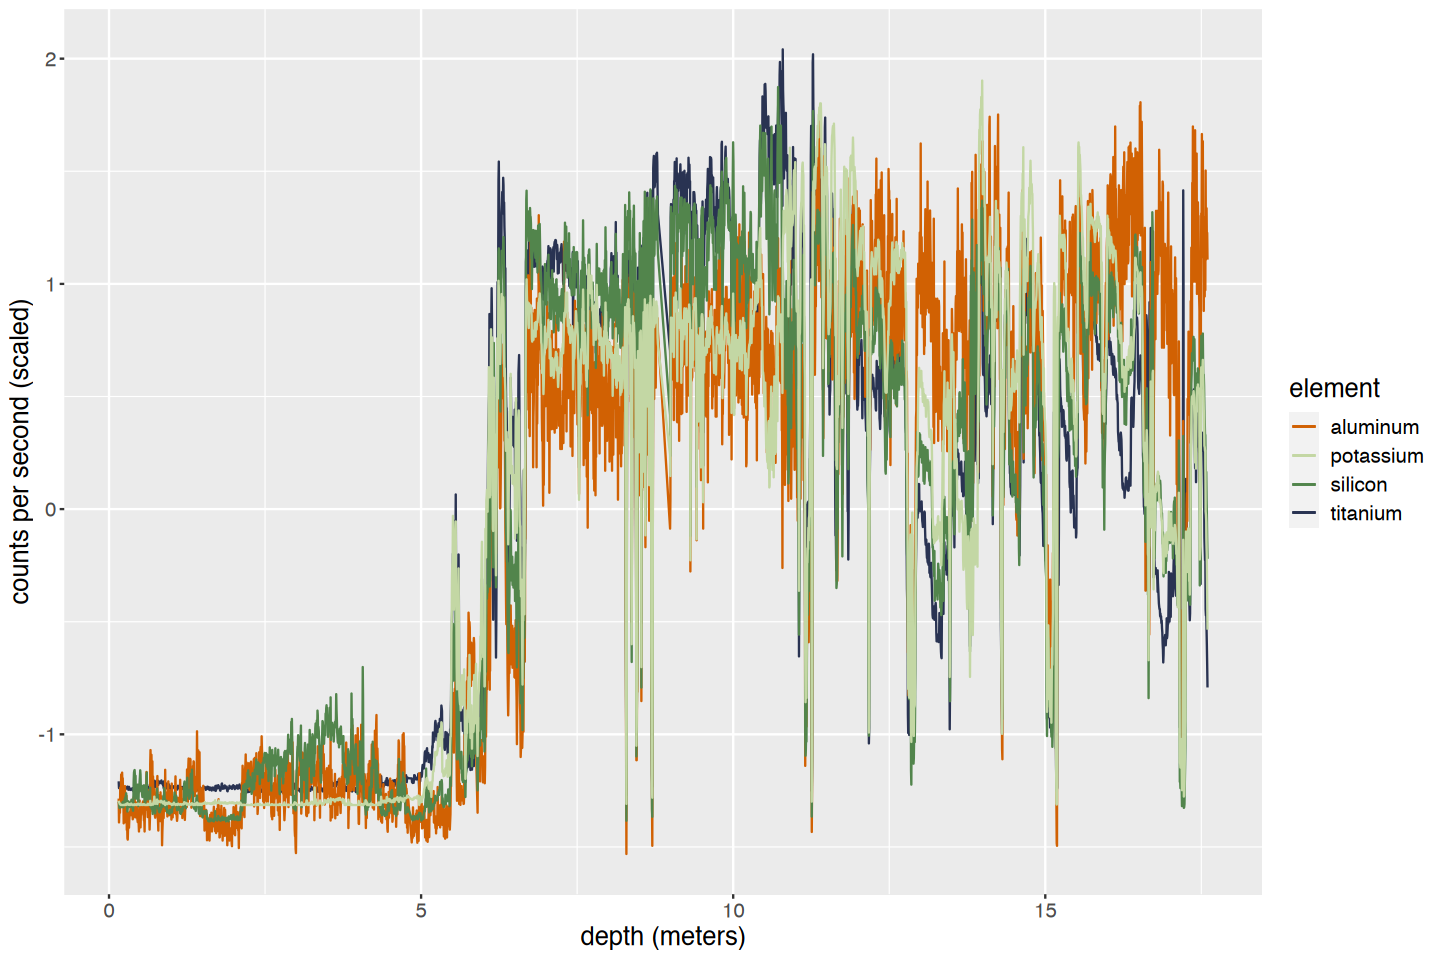

In [304]:
ggplot(
  data = xrf,
  mapping = aes(x = depth_m)) +
  geom_line(mapping = aes(y = scale(titanium), color = 'titanium')) +
  geom_line(mapping = aes(y = scale(aluminum), color = 'aluminum')) +
  geom_line(mapping = aes(y = scale(silicon), color = 'silicon')) +
  geom_line(mapping = aes(y = scale(potassium), color = 'potassium')) +
  scale_colour_manual(name="element",
                      values=c("#D16103", "#C3D7A4", "#52854C", "#293352")) + 
  labs(y = "counts per second (scaled)") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

## <b>Clastic Flux</b>

Clastic flux is a measure of rock fragments ("clasts") derived mainly from quartz particles and clay minerals via erosion of bedrock. Flux refers to the transport of these minerals that are washed into the lake, and is measured in grams/cm<sup>2</sup>/year.


In [305]:
flux <- flux_original |> 
  rename(clastic_flux_gcm2yr = siliclastic.flux.g.cm2.yr,
         depth_m = compDepthCol,
         age = bacon22.weighted.mean.age) |> 
  select(age, depth_m, clastic_flux_gcm2yr)

In [306]:
colSums(is.na(flux))

age             depth_m clastic_flux_gcm2yr 
                  0                   0                   0

In [307]:
glimpse(flux)

Rows: 759
Columns: 3
$ age                 <dbl> 282.5, 311.0, 335.5, 368.0, 400.0, 429.0, 459.5, 4…
$ depth_m             <dbl> 0.175, 0.190, 0.205, 0.230, 0.255, 0.280, 0.305, 0…
$ clastic_flux_gcm2yr <dbl> 0.003531851, 0.003743486, 0.003491321, 0.003989315…


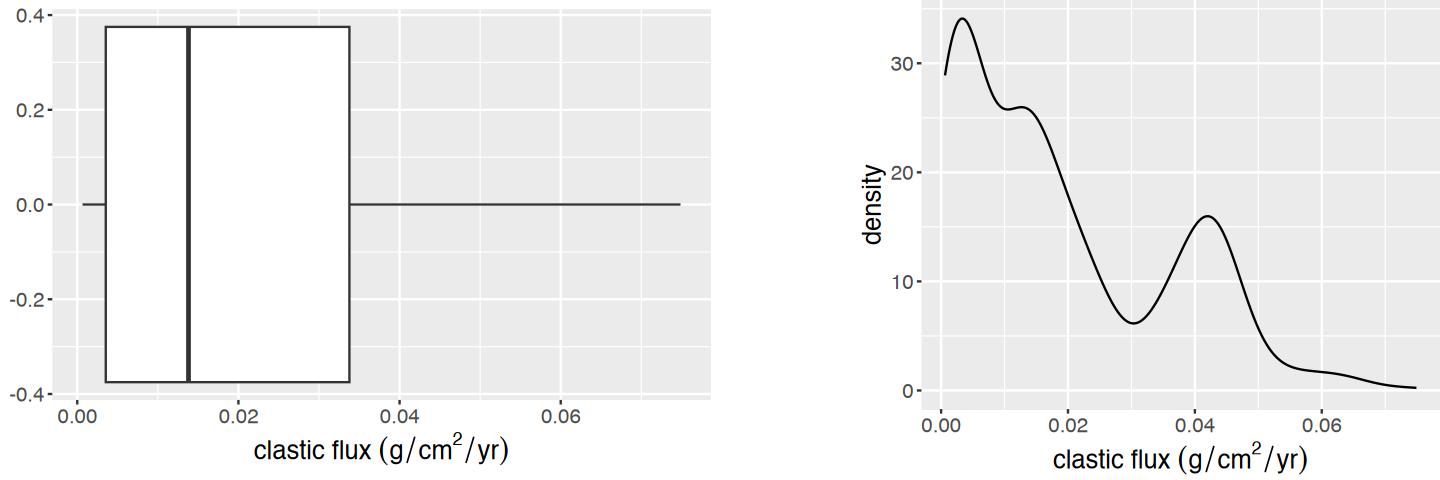

In [308]:
# Box-and-whisker and density plots to check for outliers and skew
box_plot <- ggplot(
  data = flux,
  mapping = aes(x = clastic_flux_gcm2yr)) +
  geom_boxplot(outlier.colour = 'red') +
  labs(x=bquote('clastic flux '(g/cm^2/yr))) +
  theme(text=element_text(size=15))

density_plot <- ggplot(
  data = flux,
  mapping = aes(x = clastic_flux_gcm2yr)) +
  geom_density() +
  labs(x=bquote('clastic flux '(g/cm^2/yr))) +
  theme(plot.margin=margin(l=3, unit = 'cm'),
       text=element_text(size=15))

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(box_plot, density_plot, ncol = 2, nrow = 1)


<br>

The box plot indicates there are no outliers, but the data is right-skewed and shows two modes - we will address this in a subsequent section.

## <b>Coulometry</b>

Carbon coulometry is a lab method used to quantify total organic carbon (TOC) and calcium carbonate (CaCO<sub>3</sub>) content of geologic materials; the carbonate fraction is further used to generate carbon and oxygen isotope measurements.

The original file is messy - it comprises two sets of data that were generated with different collection techniques and naming conventions, there are many missing values, and several columns with key identifying information are not filled in. 

Ultimately, this file needs to be processed by an external script which does the following:
1) reads each row to find the sediment core name and sample depth,
2) matches that info to a table/key for calculating total depth below Earth's surface, and
3) matches the total depths to radiometric age estimates from a user-generated model.

The following columns need to be populated: "Section" and "Section Depth(cm)" (required), and "SiteHole" and "Core" (required if available). 

In [309]:
# Get rid of unnecessary columns and rename them
coulometry_trimmed <- coulometry_original |> 
  select(!c(Project, Location...2, Location...3, Year, Volume, 
            Requested.Section.Depth.Top..cm., 
            Requested.Section.Depth.Bottom..cm.,
            ...28,
            Total.Inorganic.Carbon..wt.., 
            Total.Carbon..wt.., 
            Wet.bulk..density..g.cc., 
            Dry.wt...g.)) |> 
  rename(SiteHole = X1a.SiteHole,
         'Section Depth(cm)' = Sec.Depth.Midpoint.Sampled..cm.,
         section_depth_top_cm = Sec.Depth.T.Sampled,
         section_depth_bottom_cm = Sec.Depth.B.Sampled,
         splice_type = Splice.Type,
         CCLF_PLJ_depth_m = CCLF.PLJ.Depth..meters.,
         section_ID = Section.ID,
         CaCO3_wt_pct = CaCO3..wt..,
         TOC_wt_pct = Total.Organic.Carbon..wt..,
         dry_bulk_density_gcc = Dry.bulk.density..g.cc.,
         Isotope_notes_duplicates = Isotope.Notes.or.duplicates)

In [310]:
# key identifying info is missing for the first 681 rows
sum(is.na(coulometry_trimmed$Section))

# so split the data frame and work on the upper subset
coulom_subset1 <- coulometry_trimmed[1:681,]
coulom_subset2 <- coulometry_trimmed[682:4565,]

[1] 681

In [311]:
# The "Name" column contains all the info needed, but it's a string with inconsistent formatting:
coulom_subset1$Name |> head(5)

[1] "Junín C-15 D-1 0-1 cm" "Junín C-15 D-1 1-2 cm" "Junin C15 D1 2.5"     
[4] "Junín C-15 D-1 3-4 cm" "Junin C15 D1 4"


<u>Note:</u> 
In the sample names above, the core section may or may not contain hyphens:  'Junín <b>C-15 D-1</b> 1-2 cm'  or 'Junin <b>C15 D1</b> 2.5'
<br>
And the section depth may or may not contain a number range followed by "cm":  'Junín C-15 D-1 <b>1-2 cm</b>'  or 'Junin C15 D1 <b>2.5</b>'

We will use <b>regular expressions</b> to parse the "Name" column and fill in "Section" and "Section Depth(cm)".

In [312]:
# Preserve a duplicate of the Name column
coulom_subset1$NameBackup <- coulom_subset1$Name

coulom_subset1 |> head(5)

,SiteHole,Core,Section,section_ID,Section Depth(cm),CCLF_PLJ_depth_m,splice_type,section_depth_top_cm,section_depth_bottom_cm,Name,CaCO3_wt_pct,TOC_wt_pct,dry_bulk_density_gcc,d13C,d18O,Isotope_notes_duplicates,NameBackup
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
1,transect core,NA,NA,NA,NA,0.155,NA,NA,NA,Junín C-15 D-1 0-1 cm,NA,NA,NA,10.15,-6.86,NA,Junín C-15 D-1 0-1 cm
2,transect core,NA,NA,NA,NA,0.165,NA,NA,NA,Junín C-15 D-1 1-2 cm,NA,NA,NA,10.14,-6.91,NA,Junín C-15 D-1 1-2 cm
3,transect core,NA,NA,NA,2.5,0.175,NA,NA,NA,Junin C15 D1 2.5,48.31024,17.08826,0.1322,10.36,-6.90,NA,Junin C15 D1 2.5
4,transect core,NA,NA,NA,NA,0.185,NA,NA,NA,Junín C-15 D-1 3-4 cm,NA,NA,NA,10.37,-6.57,NA,Junín C-15 D-1 3-4 cm
5,transect core,NA,NA,NA,4.0,0.190,NA,NA,NA,Junin C15 D1 4,54.81358,13.96097,0.1985,NA,NA,NA,Junin C15 D1 4


In [313]:
# Split the contents of "Name" into several new columns, discard spaces and hyphens: 

coulom_subset1 <- coulom_subset1 |>
  separate_wider_regex(cols = Name,
                       patterns = c(lake = "\\w+",
                                    " ",
                                    core = "\\w",
                                    "-*",
                                    year = "\\d{2}",
                                    " ",
                                    drive = "D+",
                                    "-*",
                                    drive_num = "\\d+-*\\d*",
                                    " ",
                                    the_rest = ".*"))

coulom_subset1$drive_num <- gsub("-", "", coulom_subset1$drive_num)
coulom_subset1$SiteHole <- gsub("transect core", NA, coulom_subset1$SiteHole)

In [314]:
coulom_subset1[,10:15] |> head(5)

lake,core,year,drive,drive_num,the_rest
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Junín,C,15,D,1,0-1 cm
Junín,C,15,D,1,1-2 cm
Junin,C,15,D,1,2.5
Junín,C,15,D,1,3-4 cm
Junin,C,15,D,1,4


In [315]:
# Splitting the column "the_rest" requires additional regex functions that deal with NA values:
coulom_subset1$midpoint <- str_extract(coulom_subset1$the_rest, "\\d*.*\\d+$")
coulom_subset1$range_cm <- str_extract(coulom_subset1$the_rest, "\\d+-\\d+")

coulom_subset1[,22:24] |> head(5)

NameBackup,midpoint,range_cm
<chr>,<chr>,<chr>
Junín C-15 D-1 0-1 cm,NA,0-1
Junín C-15 D-1 1-2 cm,NA,1-2
Junin C15 D1 2.5,2.5,NA
Junín C-15 D-1 3-4 cm,NA,3-4
Junin C15 D1 4,4,NA


In [316]:
# split "range_cm" into two columns then take the average to populate missing values in the "midpoint" column
coulom_subset1 <- coulom_subset1 |> 
  separate(range_cm, c('start_cm', 'end_cm'), sep = "-") |> 
  relocate(midpoint, start_cm, end_cm, .after = drive_num) |> 
  mutate_at(c('midpoint', 'start_cm', 'end_cm'), as.numeric) |> 
  mutate(midpoint = if_else(is.na(midpoint), (start_cm + end_cm) / 2, midpoint)) |> 
  rename(Name = NameBackup) |> 
  relocate(Name, .after = section_depth_bottom_cm)

In [317]:
coulom_subset1[,10:19] |> head(5)

Name,lake,core,year,drive,drive_num,midpoint,start_cm,end_cm,the_rest
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
Junín C-15 D-1 0-1 cm,Junín,C,15,D,1,0.5,0,1,0-1 cm
Junín C-15 D-1 1-2 cm,Junín,C,15,D,1,1.5,1,2,1-2 cm
Junin C15 D1 2.5,Junin,C,15,D,1,2.5,NA,NA,2.5
Junín C-15 D-1 3-4 cm,Junín,C,15,D,1,3.5,3,4,3-4 cm
Junin C15 D1 4,Junin,C,15,D,1,4.0,NA,NA,4


In [318]:
# Populate and rearrange the columms, concatenate the cleaned data frames
coulom_subset1 <- coulom_subset1 |> 
  unite(Section, c(core, year, drive, drive_num), sep = "", remove = TRUE) |> 
  relocate(Section, .after = Core) |> 
  mutate(section_depth_top_cm = if_else(is.na(section_depth_top_cm), start_cm, NA)) |> 
  mutate(section_depth_bottom_cm = if_else(is.na(section_depth_bottom_cm), end_cm, NA)) |> 
  mutate(`Section Depth(cm)` = if_else(is.na(`Section Depth(cm)`), midpoint, `Section Depth(cm)`)) |> 
  select(-c(lake, midpoint, start_cm, end_cm, the_rest))

coulometry_cleaned <- rbind(coulom_subset1, coulom_subset2)

coulometry_cleaned |> head(5)

SiteHole,Core,Section,section_ID,Section Depth(cm),CCLF_PLJ_depth_m,splice_type,section_depth_top_cm,section_depth_bottom_cm,Name,CaCO3_wt_pct,TOC_wt_pct,dry_bulk_density_gcc,d13C,d18O,Isotope_notes_duplicates
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
NA,NA,C15D1,NA,0.5,0.155,NA,0,1,Junín C-15 D-1 0-1 cm,NA,NA,NA,10.15,-6.86,NA
NA,NA,C15D1,NA,1.5,0.165,NA,1,2,Junín C-15 D-1 1-2 cm,NA,NA,NA,10.14,-6.91,NA
NA,NA,C15D1,NA,2.5,0.175,NA,NA,NA,Junin C15 D1 2.5,48.31024,17.08826,0.1322,10.36,-6.90,NA
NA,NA,C15D1,NA,3.5,0.185,NA,3,4,Junín C-15 D-1 3-4 cm,NA,NA,NA,10.37,-6.57,NA
NA,NA,C15D1,NA,4.0,0.190,NA,NA,NA,Junin C15 D1 4,54.81358,13.96097,0.1985,NA,NA,NA


In [319]:
# The data is then exported and processed by R scripts that read the sample info and match it to an age-depth model.
# This step (not shown here) reduces the number of rows and adds columns for depth and age. The resulting data frame:
coulometry_final <- data.frame(read_xlsx('~/JuninJupyterNotebook/coulometry_final.xlsx'))

### <b>Carbon</b>

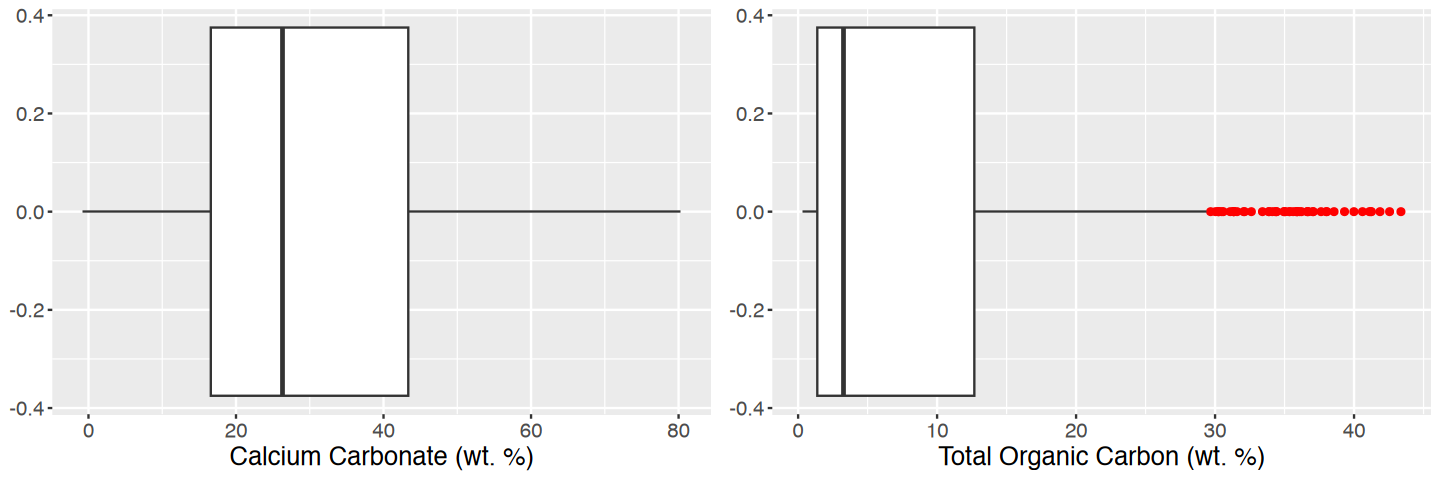

In [321]:
# Create data frame with CaCO3 and TOC
carbon <- coulometry_final |> 
  select(c(1:4, 14:15, 18)) |> 
  drop_na()

# Check for outliers with box plots 
carbon1 <- ggplot(
  data = carbon,
  mapping = aes(x = CaCO3_wt_pct)) +
  geom_boxplot(outlier.colour = 'red') + 
  labs(x = 'Calcium Carbonate (wt. %)') +
  theme(text=element_text(size=15))

carbon2 <- ggplot(
  data = carbon,
  mapping = aes(x = TOC_wt_pct)) +
  geom_boxplot(outlier.colour = 'red') +
  labs(x = 'Total Organic Carbon (wt. %)') +
  theme(text=element_text(size=15))

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(carbon1, carbon2, ncol = 2, nrow = 1)


<br>
Both data sets are right-skewed, and the box plot indicates a large number of outliers for TOC - however, these samples are actually sedimentary peat layers, which are naturally high in organic carbon and an important piece of the story in understanding the climate and lake level in the region.
<br>
<br>
Line plots better show these high-TOC layers, which are inversely related to the amount of calcium carbonate in the sediment:
<br>
<br>

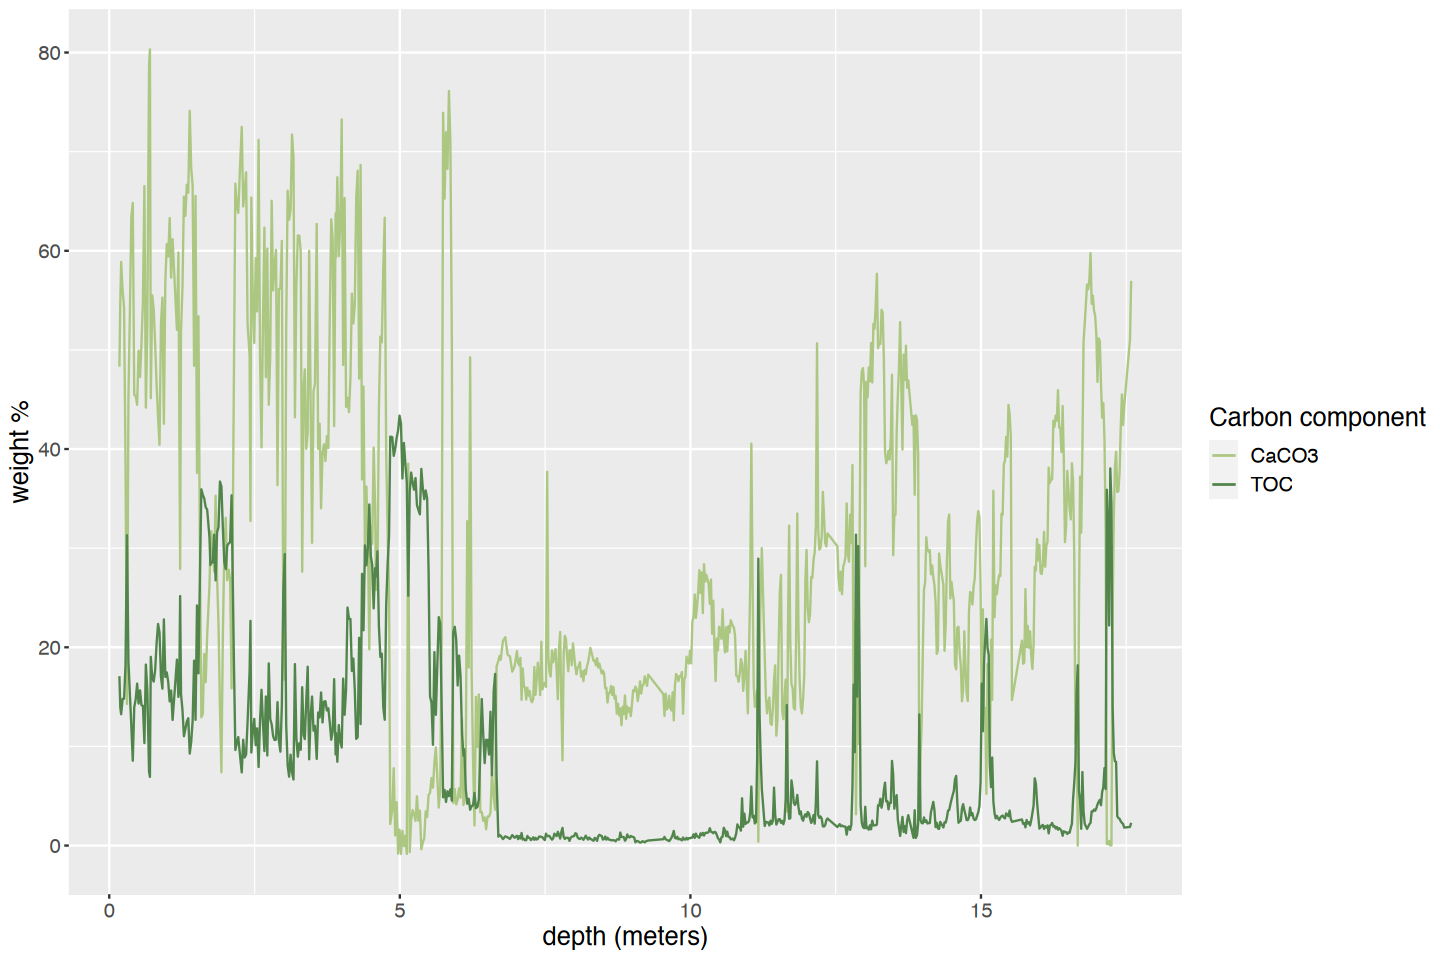

In [322]:
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(
  data = carbon,
  mapping = aes(x = depth_m)) +
  geom_line(mapping = aes(y = CaCO3_wt_pct, color = 'CaCO3')) +
  geom_line(mapping = aes(y = TOC_wt_pct, color = 'TOC')) +
  scale_colour_manual(name="Carbon component",
                    values=c("#acc781", "#52854C")) +
  labs(y = "weight %") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

### <b>Isotopes</b>

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


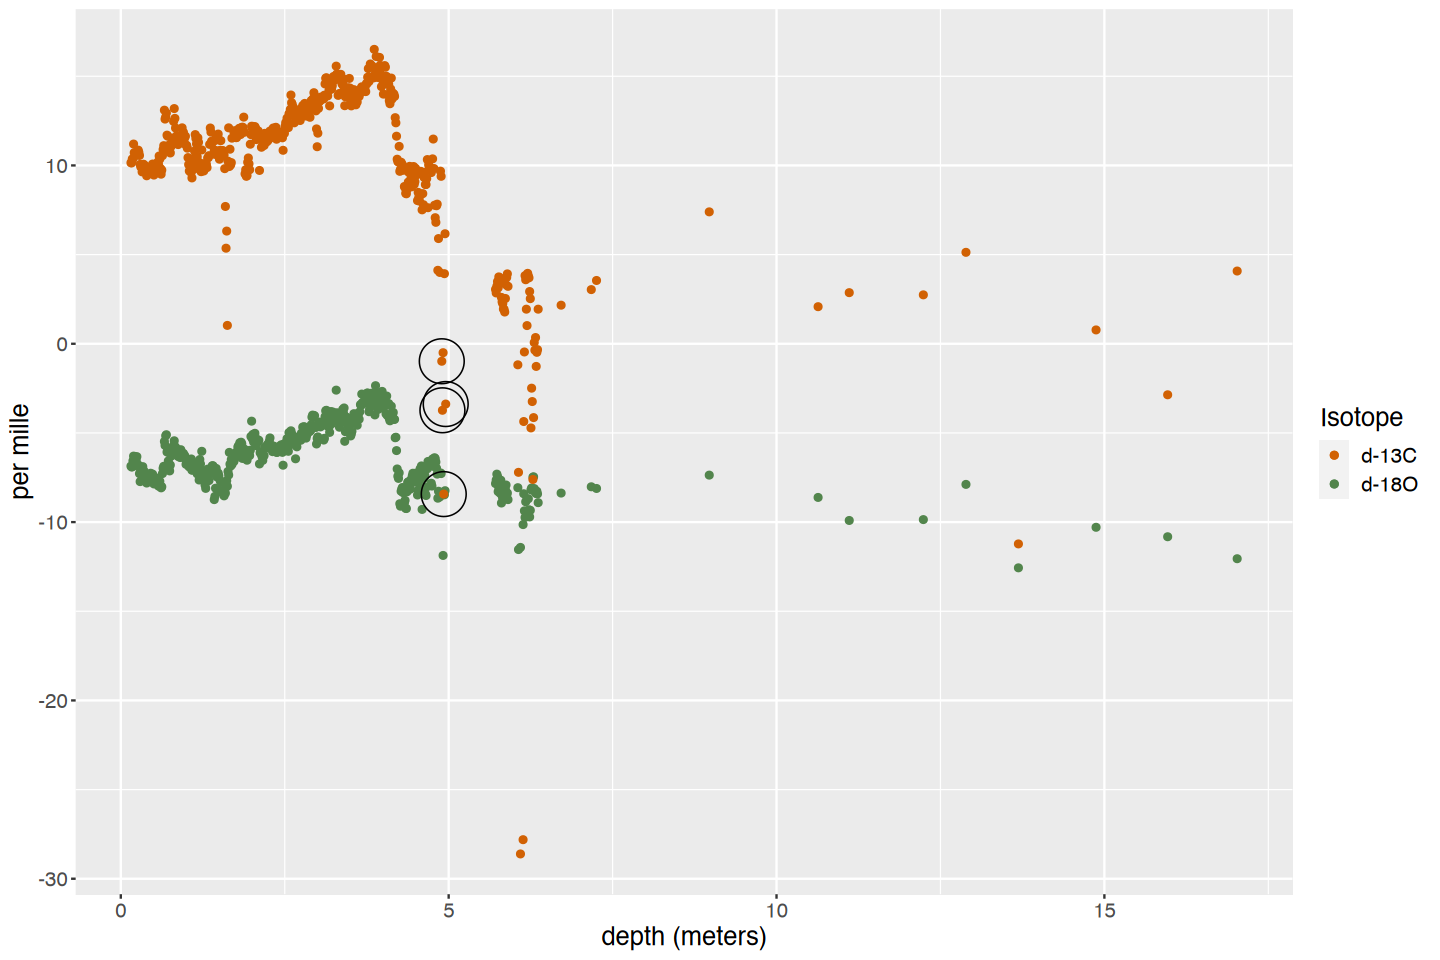

In [323]:
# Create data frame for carbon and oxygen isotopes
isotopes <- coulometry_final |> 
  select(c(1:4, d18O, d13C)) |> 
  filter(!is.na(d18O) | !is.na(d13C))

# Get rows where one column is NA and the other is not
isotopes_isolate_NA <- isotopes |> filter(is.na(d18O) | is.na(d13C))

# Plot to check if those are bad data points
options(repr.plot.width = 12, repr.plot.height = 8)             
ggplot() +
  geom_point(aes(x = isotopes$depth_m, y = isotopes$d18O, color = "d-18O")) +
  geom_point(aes(x = isotopes$depth_m, y = isotopes$d13C, color = "d-13C")) +
  geom_point(aes(x = isotopes_isolate_NA$depth_m, y = isotopes_isolate_NA$d13C), size = 12, shape = 1) + 
  scale_colour_manual(name="Isotope",
                      values=c("#D16103", "#52854C")) +
  labs(y = "per mille") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

There are 4 rows where d-13C values do not have corresponding d-18O values (circled in black); this can indicate bad instrument readings, but these samples are not otherwise unusual so we'll keep them. 

Next, check for outliers using boxplots:

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


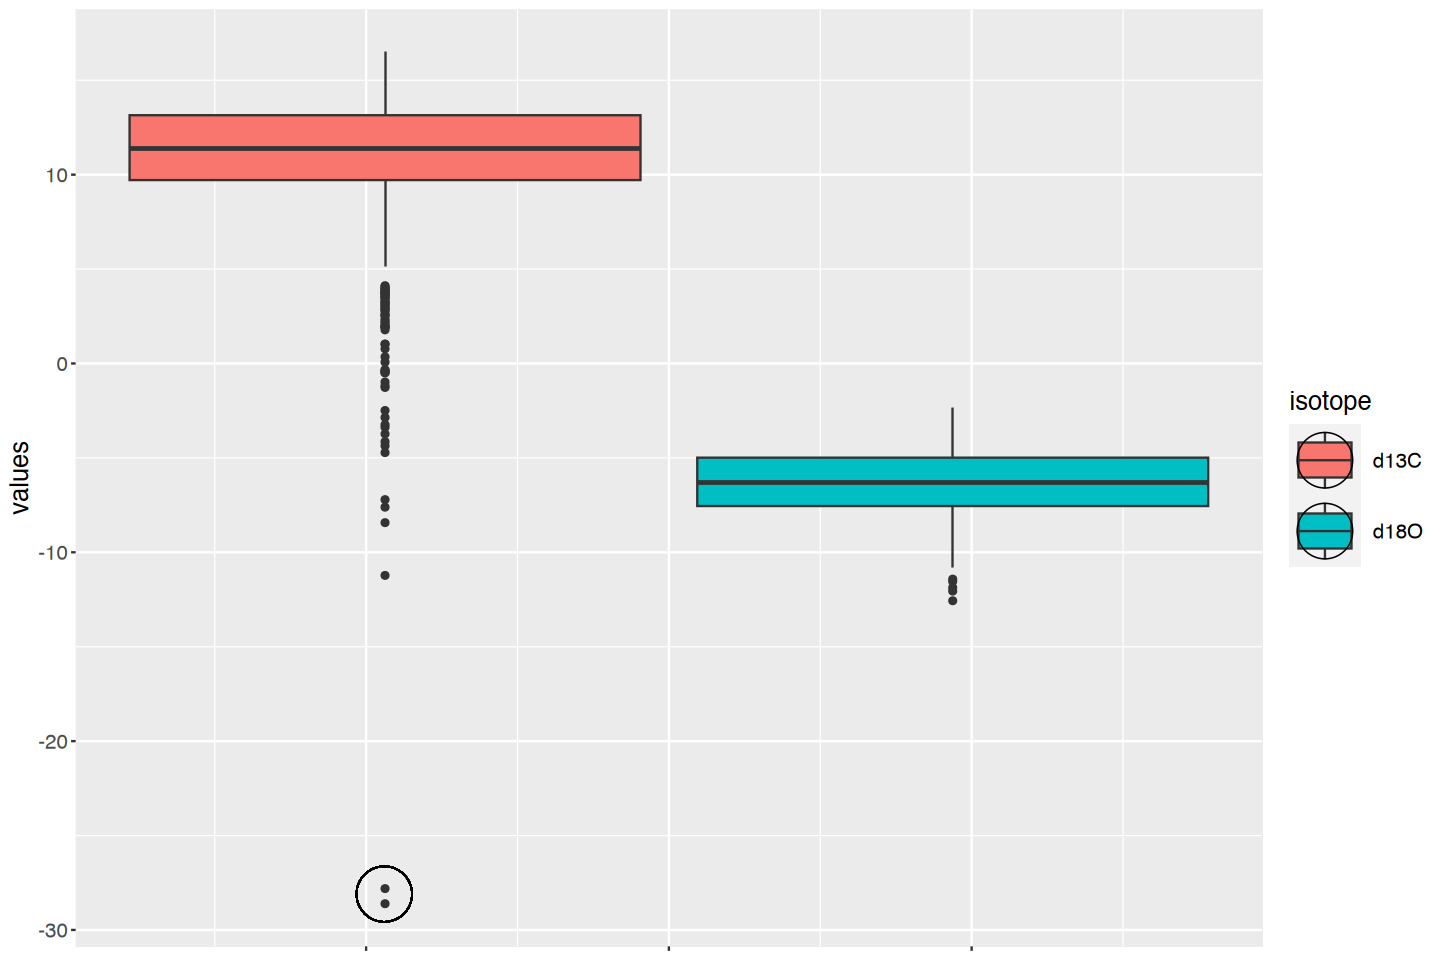

In [324]:
# pivot the data frame so we can show both isotopes in a single plot
isotopes_longer <- isotopes |> select(d18O, d13C) |> 
  pivot_longer(d18O:d13C, names_to = 'isotope', values_to = 'values')

isotopes_longer |> ggplot(
  aes(y=values, fill = isotope)) +
  geom_boxplot()  +
  geom_point(aes(x = -0.188, y = -28.1), size = 15, shape = 1) +
  theme(text=element_text(size=15),
       axis.title.x=element_blank(),
       axis.text.x=element_blank())


<br>
The box plots suggest both data sets contain outliers; however, most of these values are within the expected natural ranges for lake sediments.  The exception is d-13C values between -25 to -30 per mil (circled in black), which are not observed on earth and should be removed from the final data frame.

In [325]:
# Remove those extreme outliers
isotopes <- isotopes |> mutate(d13C = replace(d13C, d13C < -25, NA))

### <b>Bulk Density</b>

The dry bulk density data is straightforward - it contains no outliers and only needs NAs removed.

In [ ]:
density <- coulometry_final |> select(1:4, 21) |> filter(!is.na(dry_bulk_density_gcc))